# CSE 252B: Computer Vision II, Winter 2018 – Assignment 3
### Instructor: Ben Ochoa
### Due: Wednesday, February 21, 2018, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Programing):  Estimation of the camera pose - Outlier rejection (20 points)
  Download input data from the course website.  The file
  hw3_points3D.txt contains the coordinates of 60 scene points
  in 3D (each line of the file gives the $\tilde{X}_i$, $\tilde{Y}_i$,
  and $\tilde{Z}_i$ inhomogeneous coordinates of a point).  The file
  hw3_points2D.txt contains the coordinates of the 60
  corresponding image points in 2D (each line of the file gives the
  $\tilde{x}_i$ and $\tilde{y}_i$ inhomogeneous coordinates of a
  point).  The corresponding 3D scene and 2D image points contain both
  inlier and outlier correspondences.  For the inlier correspondences,
  the scene points have been randomly generated and projected to image
  points under a camera projection matrix (i.e., $\boldsymbol{x}_i = \boldsymbol{P}
  \boldsymbol{X}_i$), then noise has been added to the image point
  coordinates.

  The camera calibration matrix was calculated for a $1280 \times 720$
  sensor and $45\,^\circ$ horizontal field of view lens.  The
  resulting camera calibration matrix is given by
  
  $\boldsymbol{K} = \left[
    \begin{array}{c c c}
      1545.0966799187809 & 0 & 639.5\\
      0 & 1545.0966799187809 & 359.5\\
      0 & 0 & 1
    \end{array}\right]$
    
  For each image point $\boldsymbol{x} = (x, y, w)^\top = (\tilde{x},
  \tilde{y}, 1)^\top$, calculate the point in normalized coordinates
  $\hat{\boldsymbol{x}} = \boldsymbol{K}^{-1} \boldsymbol{x}$.

  Determine the set of inlier point correspondences using the
  M-estimator Sample Consensus (MSAC) algorithm, where the maximum
  number of attempts to find a consensus set is determined adaptively.
  For each trial, use the 3-point algorithm of Finsterwalder (as
  described in the paper by Haralick et al.) to estimate the camera
  pose (i.e., the rotation $\boldsymbol{R}$ and translation $\boldsymbol{t}$ from the
  world coordinate frame to the camera coordinate frame), resulting in
  up to 4 solutions, and calculate the error and cost for each
  solution.  Note that the 3-point algorithm requires the 2D points in
  normalized coordinates, not in image coordinates.  Calculate the
  projection error, which is the (squared) distance between projected
  points (the points in 3D projected under the normalized camera
  projection matrix $\hat{\boldsymbol{P}} = [\boldsymbol{R} | \boldsymbol{t}]$) and the
  measured points in normalized coordinates (hint: the error tolerance
  is simpler to calculate in image coordinates using $\boldsymbol{P} =
  \boldsymbol{K} [\boldsymbol{R} | \boldsymbol{t}]$ than in normalized coordinates using
  $\hat{\boldsymbol{P}} = [\boldsymbol{R} | \boldsymbol{t}]$).

 hint: this problem has codimension 2).

x is (2, 60)
X is (3, 60)
K =
[[1.54509668e+03 0.00000000e+00 6.39500000e+02]
 [0.00000000e+00 1.54509668e+03 3.59500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
R = 
[[ 0.27229329 -0.69645012  0.66393795]
 [ 0.63680066 -0.38684997 -0.66695729]
 [ 0.72134686  0.60440412  0.33816324]]
t = 
[[  4.89337039]
 [  4.93384919]
 [176.09159446]]
cost =  [195.8601029]
itterations =  44


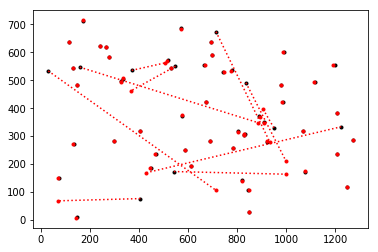

inliers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 37, 39, 40, 41, 44, 47, 48, 49]
inlier count:  39


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import logm, expm
from scipy.stats import chi2

x=np.loadtxt('hw3_points2D.txt').T
X=np.loadtxt('hw3_points3D.txt').T
print('x is', x.shape)
print('X is', X.shape)

K = np.array([[1545.0966799187809, 0, 639.5], 
      [0, 1545.0966799187809, 359.5], 
      [0, 0, 1]])

print('K =')
print(K)

def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))
def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1,:]/x[-1,:]

def proj(P,X):
    # projects 3d points X to 2d using projection matrix P
    return fromHomo(np.matmul(P,toHomo(X)))
    
    
def displayResults(R, t, K, x, X, inliers, iters, cost):
    print ('R = ')
    print (R)
    print ('t = ')
    print (t)
    print ('cost = ', cost)
    print ('itterations = ', iters)

    x_proj = proj(np.matmul(K,np.hstack((R,t))),X)
    plt.plot(x[0,:], x[1,:],'.k')
    plt.plot(x_proj[0,:], x_proj[1,:],'.r')
    for i in range(x.shape[1]):
        if i in inliers:
            line_style = '-'
        else:
            line_style = ':'
        plt.plot([x[0,i], x_proj[0,i]], [x[1,i], x_proj[1,i]], line_style+'r')

    plt.show() 

def finesterwalder(x,X,K):
    #x is (2,3)
    #X is (3,3)
    
    x=np.linalg.inv(K).dot(toHomo(x))
   
    #calculate unit vector
    j=np.zeros(x.shape)
    for i in range(x.shape[1]):
        l2norm=np.linalg.norm(x[:,i])
        j[:,i]=x[:,i]/l2norm
        if np.sign(x[2,i])<0:
            j[:,i]=j[:,i]*(-1)
    #calculate known distance a,b,c
    a=np.linalg.norm(X[:,1]-X[:,2])
    b=np.linalg.norm(X[:,0]-X[:,2])
    c=np.linalg.norm(X[:,0]-X[:,1])
    #calculate cos alpha beta gamma
    alpha=np.dot(j[:,1].T,j[:,2])
    beta=np.dot(j[:,0].T,j[:,2])
    gamma=np.dot(j[:,0].T,j[:,1])
    
    #calculate G,H,I,J
    G=c**2*(c**2*(1-beta**2)-b**2*(1-gamma**2))
    H=b**2*(b**2-a**2)*(1-gamma**2)+c**2*(c**2+2*a**2)*(1-beta**2)+2*b**2*c**2*(alpha*beta*gamma-1)
    I=b**2*(b**2-c**2)*(1-alpha**2)+a**2*(a**2+2*c**2)*(1-beta**2)+2*a**2*b**2*(alpha*beta*gamma-1)
    J=a**2*(a**2*(1-beta**2)-b**2*(1-alpha**2))
    
    #calculate the root for polynomial, find the real one
    for k in np.roots([G,H,I,J]):
        if np.isreal(k):
            lambda0=np.real(k)
            #calculate A,B,C,D,E,F
            A=1+lambda0
            B=-alpha
            C=(b**2-a**2)/b**2-lambda0*c**2/b**2
            D=-lambda0*gamma
            E=(a**2/b**2+lambda0*c**2/b**2)*beta
            F=-a**2/b**2+lambda0*(b**2-c**2)/b**2

            #calculate p,q
            if (B**2-A*C>0 and E**2-C*F>0):
                p=np.sqrt(B**2-A*C)
                q=np.sign(B*E-C*D)*np.sqrt(E**2-C*F)
                break   
    
    #calculate u,v
    uv=np.zeros((2,4))
    for i in range(2):
        if i==0:
            m=(-B+p)/C
            n=(-(E-q))/C
        else:
            m=(-B-p)/C
            n=(-(E+q))/C
    
        #calculate ularge,usmall
        A=b**2-m**2*c**2
        B=c**2*(beta-n)*m-b**2*gamma
        C=-c**2*n**2+2*c**2*n*beta+b**2-c**2
        if (B**2-A*C>0):
            ularge=-np.sign(B)/A*(abs(B)+np.sqrt(B**2-A*C))
        else:
            ularge=-1
        usmall=C/A/ularge
        vlarge=ularge*m+n
        vsmall=usmall*m+n
        uv[:,2*i:2*i+2]=np.array([[ularge,usmall],[vlarge,vsmall]])
    
    #calculate 4 solutions
    #index for p three dimension three points 4 solutions
    k=0
    p=np.zeros((3,3,4))
    for i in range(4):
        u,v=uv[:,i]
        #only keep the positive ones
        if(u>0 and v>0):
            s1=np.sqrt(b**2/(1+v**2-2*v*beta))
            #print(s1**2)
            #print(c**2/(1+u**2-2*u*gamma))
            #print(a**2/(u**2+v**2-2*u*v*alpha))
            s2=u*s1
            s3=v*s1
            p[:,0,k]=s1*j[:,0]
            p[:,1,k]=s2*j[:,1]
            p[:,2,k]=s3*j[:,2]
            k+=1
    return p[:,:,:k]

def cal_rotation(p,X):
    pmean=np.mean(p,axis=1).reshape(3,1)
    Xmean=np.mean(X,axis=1).reshape(3,1)
    pc=p-pmean
    Xc=X-Xmean
    S=np.zeros((3,3))
    for i in range(p.shape[1]):
        S=S+1/p.shape[1]*np.kron(pc[:,i].reshape(3,1),Xc[:,i].reshape(1,3))
    u,s,vh=np.linalg.svd(S)
    if (np.linalg.det(u)*np.linalg.det(vh)<0):
        R=u.dot(np.diag([1,1,-1])).dot(vh)
    else:
        R=u.dot(vh)
    t=pmean-R.dot(Xmean)
    return R,t

def MSAC(x, X, K, max_iters,p,alpha,sigma):
    """your code here"""
    maxtrails=np.inf
    mincost=np.inf
    iters = 0 # number of MSAC itterations executed
    threshhold=20 # lower bound for the size of acceptable consensus set
    #look at the chi square distribution table and find that F2^-1(0.95)=5.99
    tolerance=5.99
    num_inlier=0
    while(iters<maxtrails):
        
        #select a random sample
        indices=np.array(random.sample(range(60),3))
        
        #calculate model (up to 4 solutions)
        pp=finesterwalder(x[:,indices],X[:,indices],K)
        if (pp.size):
            iters+=1
            for i in range(pp.shape[2]):
                R,t=cal_rotation(pp[:,:,i],X[:,indices])
                #calculate error and cost
                error=np.zeros((60,1))
                cost=0
                for j in range(60):
                    # calculate projected error in image coordinates
                    error[j]=np.linalg.norm(x[:,j].reshape(2,1)-fromHomo(K.dot((R.dot(X[:,j]).reshape(3,1)+t))))**2
                    cost+=error[j] if(error[j]<=tolerance) else tolerance
                
                #update mincost and mincost model
                if(cost<mincost):
                    minerror=error
                    mincost=cost
                    mincost_R=R
                    mincost_t=t
            
            ##calculate set of inliers, update max_trails
            indices_inlier=[i for i in range(60) if minerror[i]<=tolerance]
            num_inlier=len(indices_inlier)
            if(num_inlier<=threshhold):
                break
            #print(num_inlier)
            maxtrails=np.log(1-p)/np.log(0.9-((num_inlier)/60)**60)
            #print(maxtrails)


    R = mincost_R # estimated rotation matrix
    t = mincost_t # estimated translation
    inliers = indices_inlier # indices of inliers (must be sorted)
    
    return R, t, inliers, mincost, iters

# MSAC hyperparameters (add any additional hyperparameters necessary here. For example p)
# You should pass these hyperparameters as additional paramters to MSAC(...)
p=0.99
alpha=0.95
sigma=1
max_iters=1

R_MSAC, t_MSAC, inliers, cost_MSAC, iters_MSAC = MSAC(x, X, K, max_iters,p,alpha,sigma)
displayResults(R_MSAC, t_MSAC, K, x, X, inliers, iters_MSAC, cost_MSAC)
print('inliers: ', inliers)
print('inlier count: ', len(inliers))

## Problem 2 (Programing): Estimation of the camera pose - Linear Estimate (30 points)
  Estimate the normalized camera projection matrix
  $\hat{\boldsymbol{P}}_\text{linear} = [\boldsymbol{R}_\text{linear} |
  \boldsymbol{t}_\text{linear}]$ from the resulting set of inlier
  correspondences using the linear estimation method (based on the
  EPnP method) described in lecture.

R = 
[[ 0.27624462 -0.69317918  0.66572632]
 [ 0.65453049 -0.37152958 -0.6584494 ]
 [ 0.70376043  0.61763128  0.35107386]]
t = 
[[  5.31843849]
 [  6.83209168]
 [175.98824632]]
cost =  51.12169312567448
itterations =  1


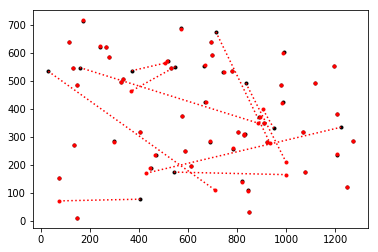

In [10]:
def EPnP(x, X, K):
    """your code here"""
    #calculate alpha_ij in world coordinate frame
    mean_X=np.mean(X,axis=1)
    cov_X=np.cov(X)
    U,D,VT=np.linalg.svd(cov_X)
    sigmax=np.sum(D)
    S=np.sqrt(np.sum(D)/3)
    
    alpha=np.zeros((4,(x.shape[1])))
    for i in range(x.shape[1]):
        alpha[1:4,i:i+1]=1/S*VT.dot((X[:,i]-mean_X).reshape(3,1))
        alpha[0,i]=1-sum(alpha[1:4,i])
    #print(X[:,i])
    #print(mean_X+S*VT.T[:,0]*alpha[1,i]+S*VT.T[:,1]*alpha[2,i]+S*VT.T[:,2]*alpha[3,i])
    
    #calculate control points in camera coordinate frame
    x_nl=fromHomo(np.linalg.inv(K).dot(toHomo(x)))
    M=np.zeros((2*x.shape[1],12))
    for i in range(x.shape[1]):
        xx=x_nl[0,i]
        yy=x_nl[1,i]
        a1=alpha[0,i]
        a2=alpha[1,i]
        a3=alpha[2,i]
        a4=alpha[3,i]
        M[2*i:2*i+2,:]=np.array([[a1,0,-a1*xx,a2,0,-a2*xx,a3,0,-a3*xx,a4,0,-a4*xx],
                                 [0,a1,-a1*yy,0,a2,-a2*yy,0,a3,-a3*yy,0,a4,-a4*yy]])
    
    #use svd to calculate null space of M
    u,sigma,vv=np.linalg.svd(M)
    index=np.where(sigma==np.min(sigma))
    Ccol=vv[index[0][0],:]
    C=Ccol.reshape(4,3).T
    X_cam=np.zeros((3,x.shape[1]))
    
    for i in range(x.shape[1]):
        X_cam[:,i]=alpha[0,i]*C[:,0]+alpha[1,i]*C[:,1]+alpha[2,i]*C[:,2]+alpha[3,i]*C[:,3]
        
    #scale 3D points in camera coordinate fram
    _,D,_=np.linalg.svd(np.cov(X_cam))
    mean_cam=np.mean(X_cam,axis=1)
    sigmacam=np.sum(D)
    beta=-np.sqrt(sigmax/sigmacam) if mean_cam[2]<0 else np.sqrt(sigmax/sigmacam)
    X_cam=beta*X_cam
    R,t=cal_rotation(X_cam,X)
    xproj=fromHomo(R.dot(X)+t)
    
    #propagate covariance 
    A=np.linalg.inv(K)[0:2,0:2]
    Sigmax=A.dot(A.T)

    #calculate cost in normalized 2D coordinates
    epsilon_x=(fromHomo(np.linalg.inv(K).dot(toHomo(x)))-xproj)
    cost=0
    #cost1=0
    for j in range(x.shape[1]):
        #cost1+=np.linalg.norm(x[:,j].reshape(2,1)-fromHomo(K.dot(R.dot(X[:,j]).reshape(3,1)+t)))**2
        cost+=epsilon_x[:,j].T.dot(np.linalg.inv(Sigmax)).dot(epsilon_x[:,j])
    
    return R, t, cost

R_EPnP, t_EPnP, cost_EPnP = EPnP(x[:,inliers], X[:,inliers], K)
displayResults(R_EPnP, t_EPnP, K, x, X, inliers, 1, cost_EPnP)

### Problem 3 (Programing): Estimation of the camera pose - Nonlinear Estimate (30 points) 
  Use $\boldsymbol{R}_\text{linear}$ and $\boldsymbol{t}_\text{linear}$ as an
  initial estimate to an iterative estimation method, specifically the
  Levenberg-Marquardt algorithm, to determine the Maximum Likelihood
  estimate of the camera pose that minimizes the projection error
  under the normalized camera projection matrix $\hat{\boldsymbol{P}} =
  [\boldsymbol{R} | \boldsymbol{t}]$.  You must parameterize the camera rotation
  using the angle-axis representation $\boldsymbol{\omega}$ (where
  $[\boldsymbol{\omega}]_\times = \ln \boldsymbol{R}$) of a 3D rotation, which is
  a 3-vector.

iter 1 cost 51.1216931257
iter 2 cost 51.1216697315
iter 3 cost 51.1216557904
iter 4 cost 51.1216486131
iter 5 cost 51.1216461953
iter 6 cost 51.1216461514
iter 7 cost 51.1216461354
iter 8 cost 51.1216461352
R = 
[[ 0.27624413 -0.69317948  0.66572621]
 [ 0.65452999 -0.37153014 -0.65844957]
 [ 0.70376109  0.6176306   0.35107374]]
t = 
[[  5.31843873]
 [  6.83209085]
 [175.98824694]]
cost =  51.12164613522649
itterations =  8


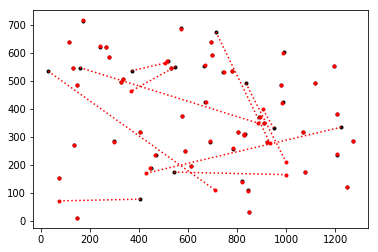

In [12]:
def R2w(R):
    # given a rotation matrix R return the angle-axis representation
    """your code here"""
    vecw=logm(R)
    w=np.array([vecw[2,1],vecw[0,2],vecw[1,0]])
    return w
def w2R(w):
    # given the angle-axis representation w return the rotation matrix
    """your code here"""
    return expm(vectomat(w))
def vectomat(x):
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])
def sinc(x):
    if x==0:
        return 1
    else:
        return np.sin(x)/x
def Jacobian(w,t,X):
    R=w2R(w)
    theta=np.linalg.norm(w)
    s=(1-np.cos(theta))/theta**2
    
    #normalized 2d inhomogeneous coordinates
    X_rotated=R.dot(X)
    x_nl=fromHomo(X_rotated)
    A=np.zeros((2*X.shape[1],6))
    for i in range(X.shape[1]):
        #calculate partial x/partial omega
        w3=(X_rotated[2,i]+t[2])[0]
        x_t=np.array([[1/w3,0,-x_nl[0,i]/w3],[0,1/w3,-x_nl[1,i]/w3]])
        if theta==0:
            Xrot_w=vectomat(-X[:,i])
        else:
            s=(1-np.cos(theta))/theta**2
            #print(s*(vectomat(w).dot(vectomat(-X[:,i]))+vectomat(-np.cross(w,X[:,i]))))
            #print(np.cross(w,X[:,i]))
            Xrot_w=sinc(theta)*vectomat(-X[:,i])+np.kron(np.cross(w,X[:,i]).reshape(3,1)*(
                np.cos(theta)/theta-np.sin(theta)/theta**2),w)/theta+np.kron(np.cross(w,
                np.cross(w,X[:,i])).reshape(3,1)*(theta*np.sin(theta)-2*(1-np.cos(theta)))/theta**3,
                w)/theta+s*(vectomat(w).dot(vectomat(-X[:,i]))+vectomat(-np.cross(w,X[:,i])))
        A[2*i:2*i+2,0:3]=x_t.dot(Xrot_w)
        #calculate partial x/partial t
        A[2*i:2*i+2,3:6]=x_t

    return A    

def LMstep(w, t, x, X, K, l, v):
    # inputs:
    # w current estimate of rotation in angle-axis representation
    # t current estimate of t
    # x 2D points
    # X 3D points
    # K camera calibration matrix 
    # l LM lambda parameter
    # v LM change of lambda parameter
    # output:
    # R updated by a single LM step
    # t updated by a single LM step
    # cost
    # l accepted lambda parameter
    
    """your code here"""
    
    #calculate current error
    R=w2R(w)
    xproj=fromHomo(K.dot(R.dot(X)+t))
    epsilon_x=(x-xproj)
    
    #propagate covariance 
    A=np.linalg.inv(K)[0:2,0:2]
    Sigmax=A.dot(A.T)

    
    #calculate normalized covariance matrix
    J=np.linalg.inv(K)[0:2,0:2]
    Sigmax=J.dot(J.T)
    
    A=Jacobian(w,t,X)
    U=np.zeros((6,6))
    epsilon_a=np.zeros((6,1))
    error=np.sum(epsilon_x*epsilon_x)
    for i in range(X.shape[1]):
        U+=A[2*i:2*i+2,:].T.dot(Sigmax).dot(A[2*i:2*i+2,:])
        epsilon_a=epsilon_a+A[2*i:2*i+2,:].T.dot(Sigmax).dot(epsilon_x[:,i]).reshape(6,1)
    
    flag=True
    while flag:
        
        delta=np.linalg.inv(U+l*np.eye(6)).dot(epsilon_a)
        wcandidate=w+delta[0:3].reshape(3,)
        tcandidate=t+delta[0:3]
        
        epsilon_xnl=(fromHomo(np.linalg.inv(K).dot(toHomo(x)))-fromHomo((w2R(wcandidate).dot(X)+tcandidate)))
        cost=0
        
        for j in range(x.shape[1]):
            cost+=epsilon_xnl[:,j].T.dot(np.linalg.inv(Sigmax)).dot(epsilon_xnl[:,j])

        
        xproj=fromHomo(K.dot(w2R(wcandidate).dot(X)+tcandidate))
        epsilon_x1=(x-xproj)
        error_1=np.sum(epsilon_x1*epsilon_x1)
        if error_1<error:
            #print('error = %.20f'%(error_1))
            flag=False
            l=0.1*l
        else:
            l=10*l
            
    #calculate cost in normalized 2D coordinates
    epsilon_xnl=(fromHomo(np.linalg.inv(K).dot(toHomo(x)))-fromHomo((R.dot(X)+t)))
    cost=0
    #cost1=0
    for j in range(x.shape[1]):
        #cost1+=np.linalg.norm(x[:,j].reshape(2,1)-fromHomo(K.dot(R.dot(X[:,j]).reshape(3,1)+t)))**2
        cost+=epsilon_xnl[:,j].T.dot(np.linalg.inv(Sigmax)).dot(epsilon_xnl[:,j])
    
    return wcandidate, tcandidate, cost, l

# use linear estimate as an initalization for LM
w_LM = R2w(R_EPnP)
t_LM = t_EPnP

# LM hyperparameters
l=.001
v=10
max_iters=10
prevcost=np.inf
i=0
# LM optimization loop
while True:
    w_LM, t_LM, cost_LM, l = LMstep(w_LM, t_LM, x[:,inliers], X[:,inliers], K, l, v)
    print ('iter %d cost %.10f'%(i+1, cost_LM))
    if (1-cost_LM/prevcost)<1e-10:
        break
    prevcost=cost_LM
    i+=1
R_LM = w2R(w_LM)
    
displayResults(R_LM, t_LM, K, x, X, inliers, i+1, cost_LM)